In [44]:
# Hyperparameters
test_results = True
T = 15 # Simulation time
N = 10 # MPC horizon
n_from_index = 0 # How distant the first point is
frame_rate = 10

In [45]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_trajectory, get_position, my_odometry


In [46]:
plt.rcParams['figure.figsize'] = [7, 7]

In [47]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [48]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate
)

In [49]:
#env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]
env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

In [50]:
dt = 1.0 / env.frame_rate

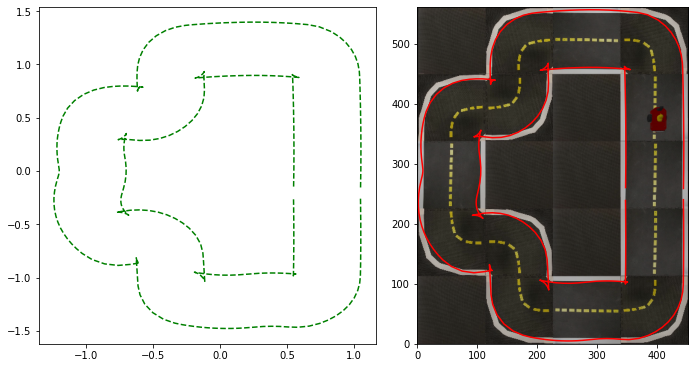

In [51]:
env.reset()
traj = get_trajectory(env, samples=200, method="distance", last_value_distance=1.0)
traj = traj + np.array([-1.25, -1.5])
inside, outside = utils.get_border(traj, distance=0.25)
#traj = 0.8 * traj
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AB""")
ax_dict["A"].plot(*inside.T, "g--")
ax_dict["A"].plot(*outside.T, "g--")
utils.show_on_map_array(env, inside - np.array([-1.25, -1.5]), fig=ax_dict["B"])
utils.show_on_map_array(env, outside- np.array([-1.25, -1.5]), fig=ax_dict["B"])

In [52]:
def curvature(x,y):
    #x = traj[:,0]
    #y = traj[:,1]
    # approximate 1st derivatives of x & y with discrete differences
    dx  = 0.5*(x[2:]-x[:-2])
    dy  = 0.5*(y[2:]-y[:-2])
    dl  = sqrt(dx**2 + dy**2)
    xp  = dx/dl
    yp  = dy/dl
    # approximate 2nd derivatives of x & y with discrete differences
    xpp = (x[2:]-2*x[1:-1]+x[:-2])/(dl**2)
    ypp = (y[2:]-2*y[1:-1]+y[:-2])/(dl**2)

    # Compute the curvature
    curvature = (xp*ypp - yp*xpp) / ((xp**2 + yp**2)**(1.5))
    return curvature

In [53]:
#traj = inside
x_min = traj[:,0].min()
y_min = traj[:,1].min()

In [54]:
pose = get_position(env)
pose.x = 0.79
pose.y = 0.0
pose.theta = pi/2

In [55]:
pose

Position(x=0.79, y=0.0, theta=1.5707963267948966)

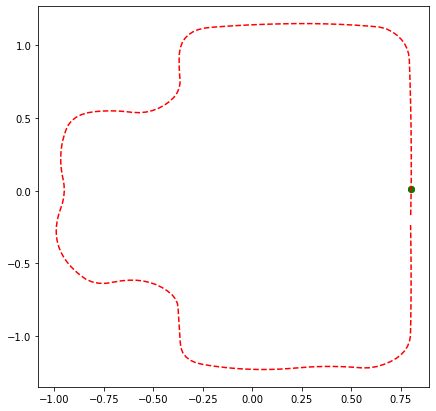

In [56]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
pose.x = traj[index,0]
pose.y = traj[index,1]
index += n_from_index
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

In [57]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 124.0'

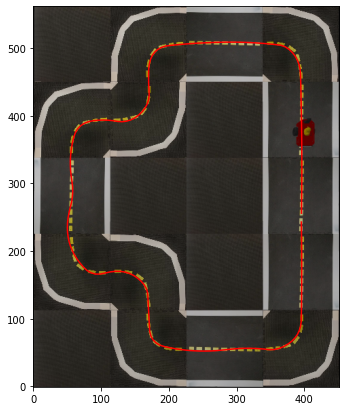

In [58]:
utils.show_on_map_array(env, traj[:,:2] - np.array([-1.25, -1.5]))

In [59]:
#get_position(env)

In [60]:
# # Compute the angle between every consecutive points in traj
# angles = np.zeros(traj.shape[0])
# for i in range(traj.shape[0]-1):
#     angles[i] = np.arctan2(traj[i+1,1]-traj[i,1], traj[i+1,0]-traj[i,0])
# angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [61]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
angles[angles < 0] += 2 * np.pi

In [62]:
idx = []
for i in range(len(angles)-1):
    if mod((angles[i] - angles[i+1]),pi) >= pi/2:
        idx.append(i)

In [63]:
#angles = np.delete(angles, idx)
#traj = np.delete(traj, idx, 0)

In [64]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [65]:
# traj = np.repeat(traj, 6, axis=0)
# traj.shape

In [66]:
# Drop values to fix weird final angle
# traj = traj[1:-1]

Plot angles:

If faces right red, else blue

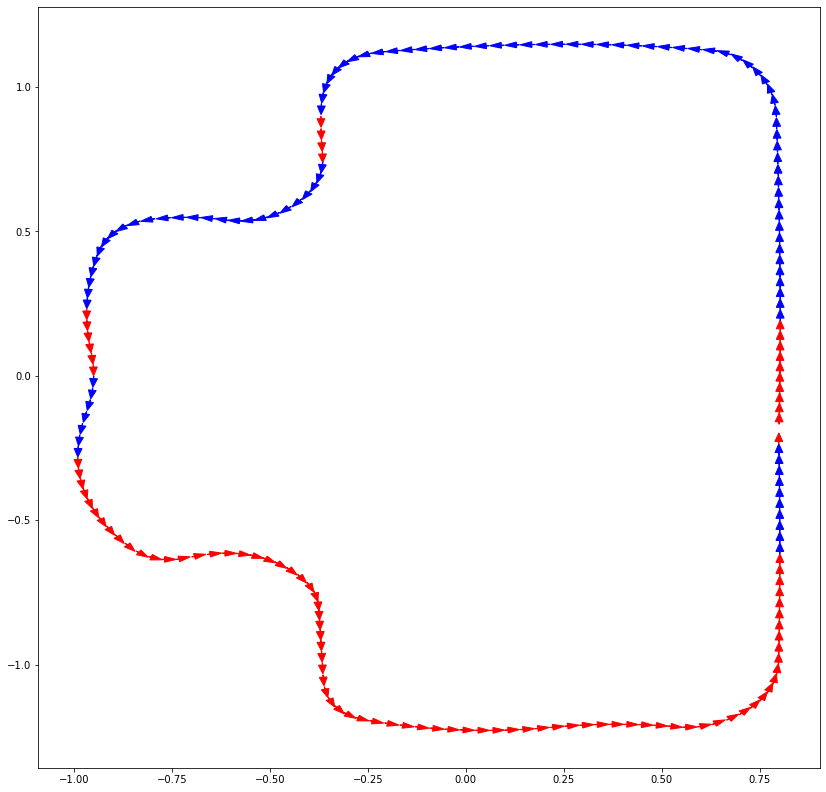

In [67]:
c="r"
fig = plt.figure(figsize=(14,14))
for x, y, t in traj:#[::3]:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = "b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.008*np.sin(t), color=c, head_width=0.02)

In [68]:
traj[index]

array([0.80163005, 0.00853932, 1.56324901])

In [69]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [70]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

In [71]:
#pose = get_position(env)

DAE

In [72]:
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[0.80163, 0.00853932, 1.5708, 0.3, 0]


In [73]:
x0

MX(x)

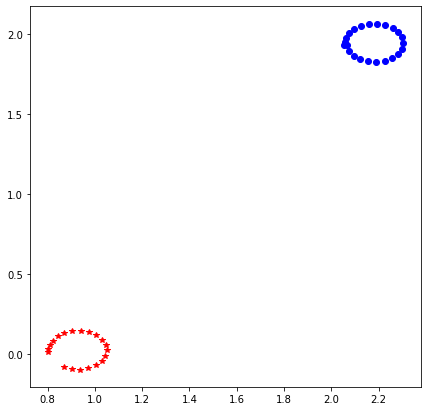

In [74]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = np.array(sim(x0, [1, 0.2]))
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [86]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T
ins0 = DM(inside)[index:index+N+1, :].T

In [87]:
#def mod(n, base):
#    return n - floor(n/base) * base

In [88]:
#weights_0 = [1e3, 1e2, 1e-2, 1]
weights_0 = [1, 1, 1, 0, 0, 0]
theta_0 = [0, 0, 0, 0]
gamma = 0.9

In [89]:
def position_cost(x,r):
    delta = 10
    return delta**2 * (np.sqrt(1 + (((x[0]-r[0])**2 + (x[1]-r[1])**2)/delta**2))-1)
def heading_cost(psi,tr):
    return (1 - np.cos(psi - tr))/2

In [230]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
slack = opti.variable(1,N+1)
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
ins = opti.parameter(2,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay

weights = opti.parameter(6)
theta = opti.parameter(4)

Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
Q4 = weights[3]
Q5 = weights[4]
R = weights[5]

theta_lambda = theta[0]
theta_f_1 = theta[1]
theta_f_2 = theta[2]
theta_f_3 = theta[3]
# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
#obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)#R*sumsqr(u[:,1:]-u[:,:-1])
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

        # Setup the problem 

# Constraints Definition
cost = theta_lambda # initial cost

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
    cost += gamma**k * (Q1*position_cost(x[:2, k], r[:,k]) +\
                        Q2*heading_cost(x[2, k],tr[:,k]) +\
                        #Q3*sumsqr(x[3, k]-0.6) +\
                        Q4*sumsqr(x[:2,k] - ins[:,k]) +\
                        .1 * slack[:,k]
                        #Q4*sumsqr(x[4, k]) +\
                        #R*sumsqr(u[:,k])
                        )
    # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))

#print(x[0,:].shape)
#cost += Q5*sumsqr(curvature(x[0, :3],x[1, :3]))#Q5*sumsqr(curvature(r[0, :],r[1, :]))
cost += gamma**N * (theta_f_1*sumsqr(x[:2, N]-r[:,N])+ theta_f_2*heading_cost(x[2, k],tr[:,k]) + theta_f_3*sumsqr(x[3, k]-0.6))
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
#opti.subject_to(sumsqr(x[:2,:]) >= sumsqr(r[:,:]))
opti.subject_to(x[3,:] + slack >= 0.55)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(ins,ins0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay

opti.set_value(weights, weights_0)
opti.set_value(theta, theta_0)
                    
opti.minimize(cost)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()
    
V = opti.to_function('V',[p, r, tr, ins, u_delay, weights, theta], # inputs
                         [cost, u[:,0], gradient(cost + opti.lam_g.T @ opti.g, weights), gradient(cost + opti.lam_g.T @ opti.g, theta)], # outputs
                         ['p', 'r', 'tr', 'ins', 'u_delay', 'weights', 'theta'],
                         ['cost', 'u_opt', 'gradient_weights', 'gradient_theta'])

In [231]:
u_s = [.0, .0]
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
slack = opti.variable(1,N+1)
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
ins = opti.parameter(2,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay
u_0 = opti.parameter(2)

weights = opti.parameter(6)
theta = opti.parameter(4)
#beta = opti.parameter(1)

#beta1 = beta[0]
#beta2 = beta[1]

Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
Q4 = weights[3]
Q5 = weights[4]
R = weights[5]

theta_lambda = theta[0]
theta_f_1 = theta[1]
theta_f_2 = theta[2]
theta_f_3 = theta[3]

# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
#obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)#R*sumsqr(u[:,1:]-u[:,:-1])
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

        # Setup the problem 

# Constraints Definition
# Constraints Definition
cost = theta_lambda # initial cost

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
    cost += gamma**k * (Q1*position_cost(x[:2, k], r[:,k]) +\
                        Q2*heading_cost(x[2, k],tr[:,k]) +\
                        #Q3*sumsqr(x[3, k]-0.6) +\
                        Q4*sumsqr(x[:2,k] - ins[:,k]) +\
                        .1 * slack[:,k]
                        #Q4*sumsqr(x[4, k]-0.0) +\
                        #R*sumsqr(u[:,k])
                        )
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
    
#cost += Q5*sumsqr(curvature(x[0, :],x[1, :]))
cost += gamma**N * (theta_f_1*sumsqr(x[:2, N]-r[:,N])+ theta_f_2*heading_cost(x[2, k],tr[:,k]) + theta_f_3*sumsqr(x[3, k]-0.6))
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
opti.subject_to(sumsqr(x[:2,:]) >= sumsqr(r[:,:]))
opti.subject_to(x[3,:] + slack >= 0.55)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)
opti.subject_to(u[:,0] == u_0)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(ins,ins0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay
opti.set_value(u_0, u_s)

opti.set_value(weights, weights_0)
opti.set_value(theta, theta_0)

opti.minimize(cost)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()
    
Q = opti.to_function('Q',[p, r, tr, ins, u_delay, u_0, weights, theta], # inputs
                         [cost, gradient(cost + opti.lam_g.T @ opti.g, weights), gradient(cost + opti.lam_g.T @ opti.g, theta)], # outputs
                         ['p', 'r', 'tr', 'ins', 'u_delay', 'u_0', 'weights', 'theta'],
                         ['cost', 'gradient_weigths', 'gradient_theta'])

In [280]:
from skspatial.objects import Line

def stage_cost(x, r, tr, x_next, x_prev):
    # Formulation 1 for curvature
    angle_next = np.arctan2(x_next[1], x_next[0])
    if angle_next < 0:
        angle_next += 2*pi
    angle = np.arctan2(x[1], x[0])
    if angle < 0:
        angle += 2*pi
    ds = np.sqrt((x_next[0]-x[0])**2 + (x_next[1]-x[1])**2)
    dtheta = angle_next - angle#np.arctan2(x_next[1]-x[1], x_next[0]-x[0])
    if dtheta < 0:
        dtheta += 2*pi
        
    _,idx = spatial.KDTree(inside).query(np.array([x[0], x[1]]).reshape(-1))
    closest_inside = inside[idx]
        
    if True:
        x_array = np.array([x_prev[0], float(x[0]), float(x_next[0])])#np.concatenate((np.array([x[0]]).flatten(),np.array(r[0,1:]).flatten()))#
        y_array = np.array([x_prev[1], float(x[1]), float(x_next[1])])#np.concatenate((np.array([x[1]]).flatten(),np.array(r[1,1:]).flatten()))#
        x_t = np.gradient(x_array)
        y_t = np.gradient(y_array)
        vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])
        speed = np.sqrt(x_t * x_t + y_t * y_t)
        tangent = np.array([1/speed] * 2).transpose() * vel
        ss_t = np.gradient(speed)
        xx_t = np.gradient(x_t)
        yy_t = np.gradient(y_t)
        curvature_val = np.nan_to_num(np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5, 0.0)
        #print(curvature_val[1])
        vel_angle = np.arctan2(x_next[1] - x[1], x_next[0] - x[0])
        if vel_angle < 0:
            vel_angle += 2*pi
        #print(np.sin(vel_angle-angle))
        #print((x[0]-closest_inside[0])**2+(x[1]-closest_inside[1]))
        return np.abs(curvature_val[1])**2
        return np.abs(curvature_val[1])**2/((np.sin(vel_angle-angle)*x[3])**2)# + 100*(x[0]-closest_inside[0])**2+(x[1]-closest_inside[1])**2
    else:    
        # Formulation 2 for curvature
        num = np.abs((x[1]-x_prev[1])/(x[0]-x_prev[0]))
        den = (1 + ((x_prev[1]+x_next[1]-2*x_prev[1])/(x[0]-x_prev[0]))**2)**3/2
        curvature = num/den
    #print(sumsqr(curvature_val))

    #print(dtheta)
    #print(dtheta)
    
    return (dtheta/ds)
    #return np.sqrt(curvature) * (np.sqrt((x[0]-x_prev[0])**2 + (x[1]-x_prev[1])**2) + np.sqrt((x_next[0]-x[0])**2 + (x_next[1]-x[1])**2))/2
    #return (np.sqrt(x_next[0]**2+x_next[1]**2)-np.sqrt(x[0]**2+x[1]**2))**2/(np.sin(x[2]-angle)*x[3]**2)
    return np.sqrt((x_next[0]-x[0])**2 + (x_next[1]-x[1])**2)/x[3] #* np.sqrt(curvature_val[1])* 
    #THIS IS WORKING 1!!
    #return np.mean(curvature_val)**4/(x[3]-0.6)**2 #+ (x[0]**2 + x[1]**2)
    #THIS IS WORKING 1!!
    return fmin(1/((curvature_val[1])**2*(x[3])**2),10) #+ (x[0]**2 + x[1]**2)
    #print(np.sin(x[2]-angle))
    #return (x[0]**2 + x[1]**2)/((np.sin(x[2]-angle)*(x[3]))**2)
    #return ((x[0]-r[0])**2 + (x[1]-r[1])**2)/x[3]**2
    #return ((x[0]-projected_point[0])**2 + (x[1]-projected_point[1])**2)/((x[3])**2+0.001)
    #return ((x[0]-r[0,1])**2 + (x[1]-r[1,1])**2)/((x[3])**2+0.001)
    #return (x[0]-r[0,0])**2+ (x[1]-r[1,0])**2 + (x[3]-0.2)**2 + (x_next[3]-x[3])**2 + (x[4])**2

    #return (x[0]-r[0,0])**2+ (x[1]-r[1,0])**2 +(x[3]-0.6)**2 + (x_next[3]-x[3])**2 + (x[4])**2#0.001*sumsqr(curvature_val) +\
            #(x_next[4] - x[4])**2
            
            
    return weights[0] * (x[0]-r[0,0])**2 + \
           weights[0] * (x[1]-r[1,0])**2 + \
           weights[1] * (x[4]-0.0)**2 + \
           weights[2] * (x[3]-0.6)**2

# MPC loop
gamma = 0.9
alpha_1 = 1e-5
alpha_2 = 1e-5
#weights_0 = [100, 5e-4, 10, 1e-3]
#weights_0 = [1e3, 1e2, 1e-2, 1]
weights_0 = [1, 0, 0, 0, 0, 0]
#weights_0 = [1, 0.670703, 0.563058, 0, 0, 0]
#weights_0 = [0.809252, 0, 0.110079, 0, 0, 0] # for example
#weights_0 =[1.51838, 0, 1.13578, 0, 0, 0] # example with 10 weights on w
#weights_0 = [0.543969, 0.0379773, 0.0787006, 0, 0, 0] # with heading cost
#weights_0 = [0.787901, 0.0211029, 0.0806473, 0, 0, 0] #  with theta
#weights_0 = [0.273273, 0.059044, 0.0869923, 0, 0, 0] # 15k steos
#weights_0 = [0.837962, 0.000163317, 0.0322027, 0, 0, 0]# for ref speed 0.2
#weights_0 = [0.956418, 0.00251801, -0.00141281, 0, 0, 0.0216092] # for ref speed 0.2
#weights_0 = [1, 14.7023, 15.9597, 0, 0, 0] # for curvature
#weights_0 = [1, 7.13518, 10.1238, 0, 0, 0]# for curvature 2
#weights_0 = [1, 9.61111, 11.9599, 0, 0, 0] # for curvature 3
#weights_0 = [1, 824.037, 480.801, 0, 0, 0] # for curvature inside traj
#weights_0 = [1, 1.99024, 1.89642, 0, 0, 0] # for curvature inside traj 2
#theta_0 = [100, 1, 1, 1]
theta_0 = [0, 0, 0, 0]
#theta_0 = [0, -0.0342125, 0.000601827, -0.00644741]
#theta_0 = [2.27957, -0.118842, -0.00167384, -0.0227207] # 15k steps
#theta_0 = [187.82, 0.25294, -0.0283084, -0.356778] # for curvature
#theta_0 = [92.7182, 0, 0, 0] # for curvature 3
#theta_0 = [3254.27, -22.1191, -0.303924, -26.7503] # for curvature inside traj
#theta_0 = [30.0249, 0.205885, 0.0110286, -0.11331] # for curvature inside traj 2
#weights_0 = [100, 0.0148332, 10.054, 1.08164] # tuned, original 100, 5e-4, 10, 1e-3, max_speed = 0.3891 (non tuned 0.5260)
#weights_0 = [100, 0.0207271, 10.027, 0.710063] # tuned new stage cost, original 100, 5e-4, 10, 1e-3, max_speed = 0.3891 (non tuned 0.5260)
#theta_0 = [1.92382e-06, 2.81897e-09, 0.000776342] # tuned
#theta_0 = [1.17951e-06, 4.02384e-09, -2.73673e-05] # tuned stage cost new
#weights_0 = [106.582, 68.6181, 10.05, 0.106237] # test
#theta_0 = [0.111024, 1.45679, 1.56981] # test
#weights_0 = [102.703, 28.9963, 10.0181, 0.0282763] # test 2
#theta_0 = [0.0258132, 0.62772, 10.0108] # test 2

autotune = True

X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
x_prev = x
r = r0
tr = t0
ins = ins0
idx = index
u_delay = u_delay0
errors = []
error_x = []
error_y = []
error_theta = []
weights_vect = []
theta_vect = []
delta_vect = []
grad_weights_vect = []
grad_theta_vect = []

kdtree = spatial.KDTree(traj[:, :2])

_,start_idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))

x_prev = x

t = 0
flag = False
for i in range(1000):
    #print(i)
    V_cost, a, _, _ = V(x, r, tr, ins, u_delay, weights_0, theta_0)
    #print(V_cost)
    
    U_log = np.column_stack((U_log, a))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, a))[:, -delay:]

    # simulate
    x_next = F(x,a)
    
    
    Q_cost, Q_grad_weights, Q_grad_theta = Q(x, r, tr, ins, u_delay, a, weights_0, theta_0)
    #print(Q_grad)
    #
    #print(stage_cost(x, r, tr))
    #print(stage_cost_model(x, r, tr, weights_0, a))
    
    #print(delta)
    #print(abs(delta))
    #test = [1e3, 1e3, 1, 1e-1]
    #test2 = [1, 1e3, 1e3]
    #print(test * Q_grad_weights)
    #print(test2 * Q_grad_theta)
    #print(stage_cost(x, r, tr, x_next, x_prev))
    delta = stage_cost(x, r, tr, x_next, x_prev) + gamma * V(x_next, r, tr, ins, u_delay, weights_0, theta_0)[0] - Q_cost

    if autotune and i >= 20:
        weights_0 = weights_0 + alpha_1 * delta * Q_grad_weights
        weights_0[0] = 1
        theta_0 = theta_0 + alpha_1 * delta * Q_grad_theta
        theta_0[1:] = [0, 0, 0]
        #print(alpha * delta * Q_grad)
        #beta_0 = beta_0 + alpha * delta * Q_grad

    x_prev = x
    x = x_next
    
    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    errors.append(np.sqrt(distance))
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2],2*np.pi)-traj[idx, 2])
    weights_vect.append(DM(weights_0))
    theta_vect.append(DM(theta_0))
    delta_vect.append(delta)
    grad_weights_vect.append(Q_grad_weights)
    grad_theta_vect.append(Q_grad_theta)

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    
    t += 1
    if i > 10 and idx == start_idx:
        pass
        #if flag:
        #    break
        #t = 0
        #flag = True
    
    if idx+N+1 < traj.shape[0]:
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
        ins = DM(inside)[idx:idx+N+1, :].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N+1-traj.shape[0], 2]).T
        ins = vertcat(DM(inside)[idx:, :], DM(inside)[:idx+N+1-inside.shape[0], :]).T
    #r = traj[idx:idx+N+1, :2].T
    #tr = traj[idx:idx+N+1, 2].T

/tmp/ipykernel_3320/1224346101.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tangent = np.array([1/speed] * 2).transpose() * vel
/tmp/ipykernel_3320/1224346101.py:26: RuntimeWarning: invalid value encountered in multiply
  tangent = np.array([1/speed] * 2).transpose() * vel
/tmp/ipykernel_3320/1224346101.py:30: RuntimeWarning: invalid value encountered in true_divide
  curvature_val = np.nan_to_num(np.abs(xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5, 0.0)
/tmp/ipykernel_3320/1224346101.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_array = np.array([x_prev[0], float(x[0]), float(x_next[0])])#np.concatenate((np.array([x[0]]).flatten(),np.array(r[0,1:]).flatten()))#
/tmp/ipykernel_3320/1224346101.py:21: VisibleDeprecationWarning: 

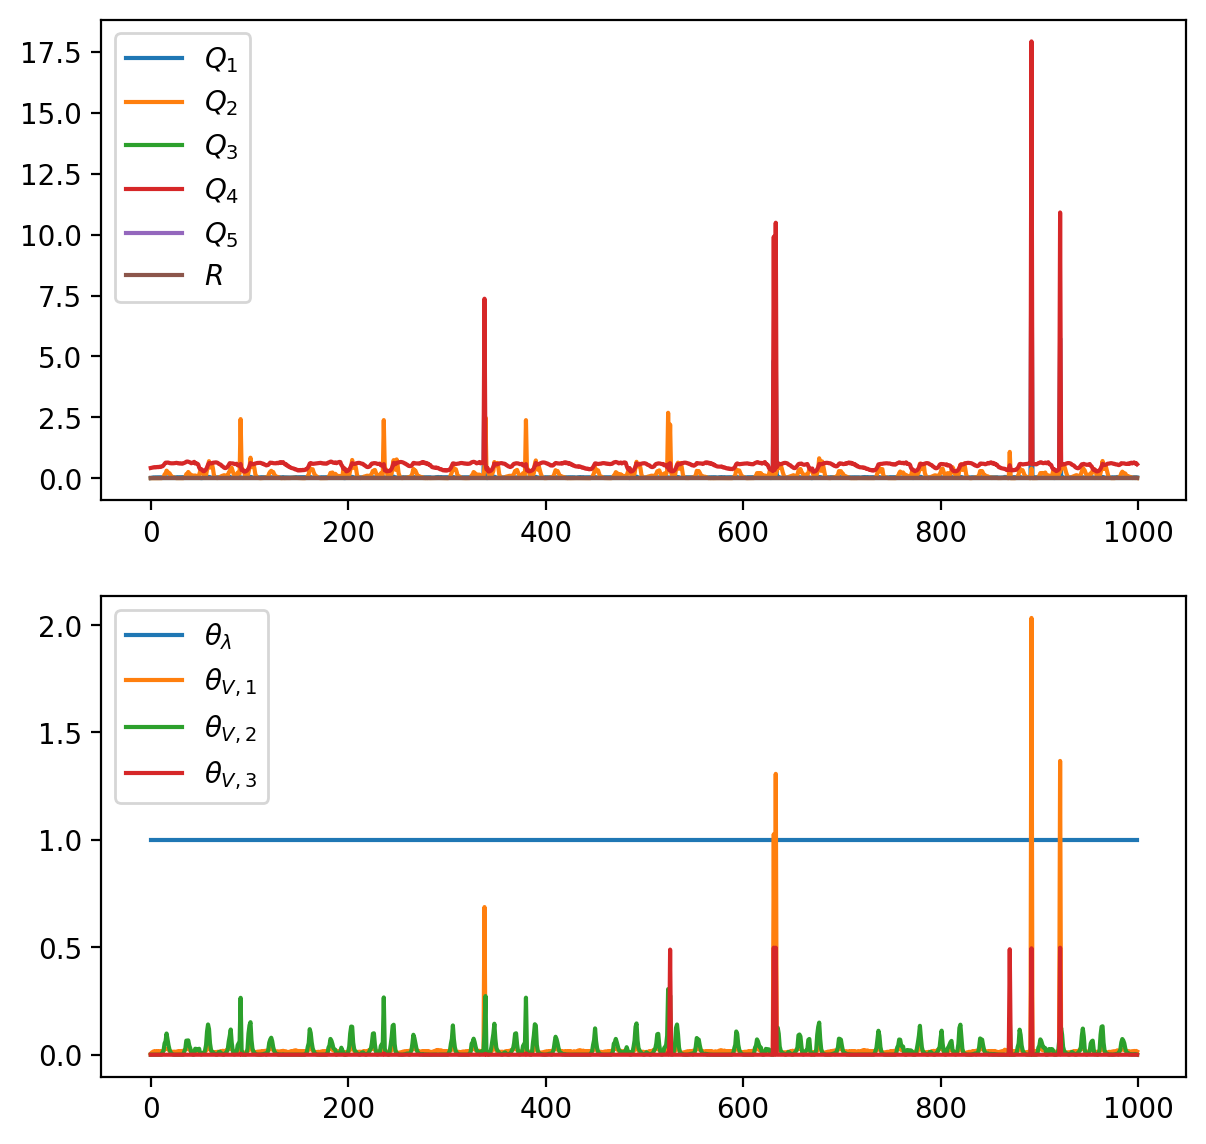

In [281]:
fig, (ax1, ax2) = plt.subplots(2,1, dpi=200)

ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,0], label='$Q_1$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,1], label='$Q_2$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,2], label='$Q_3$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,3], label='$Q_4$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,4], label='$Q_5$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,5], label='$R$')
ax1.legend()

ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,0], label=r'$\theta_{\lambda}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,1], label=r'$\theta_{V,1}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,2], label=r'$\theta_{V,2}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,3], label=r'$\theta_{V,3}$')
ax2.legend()

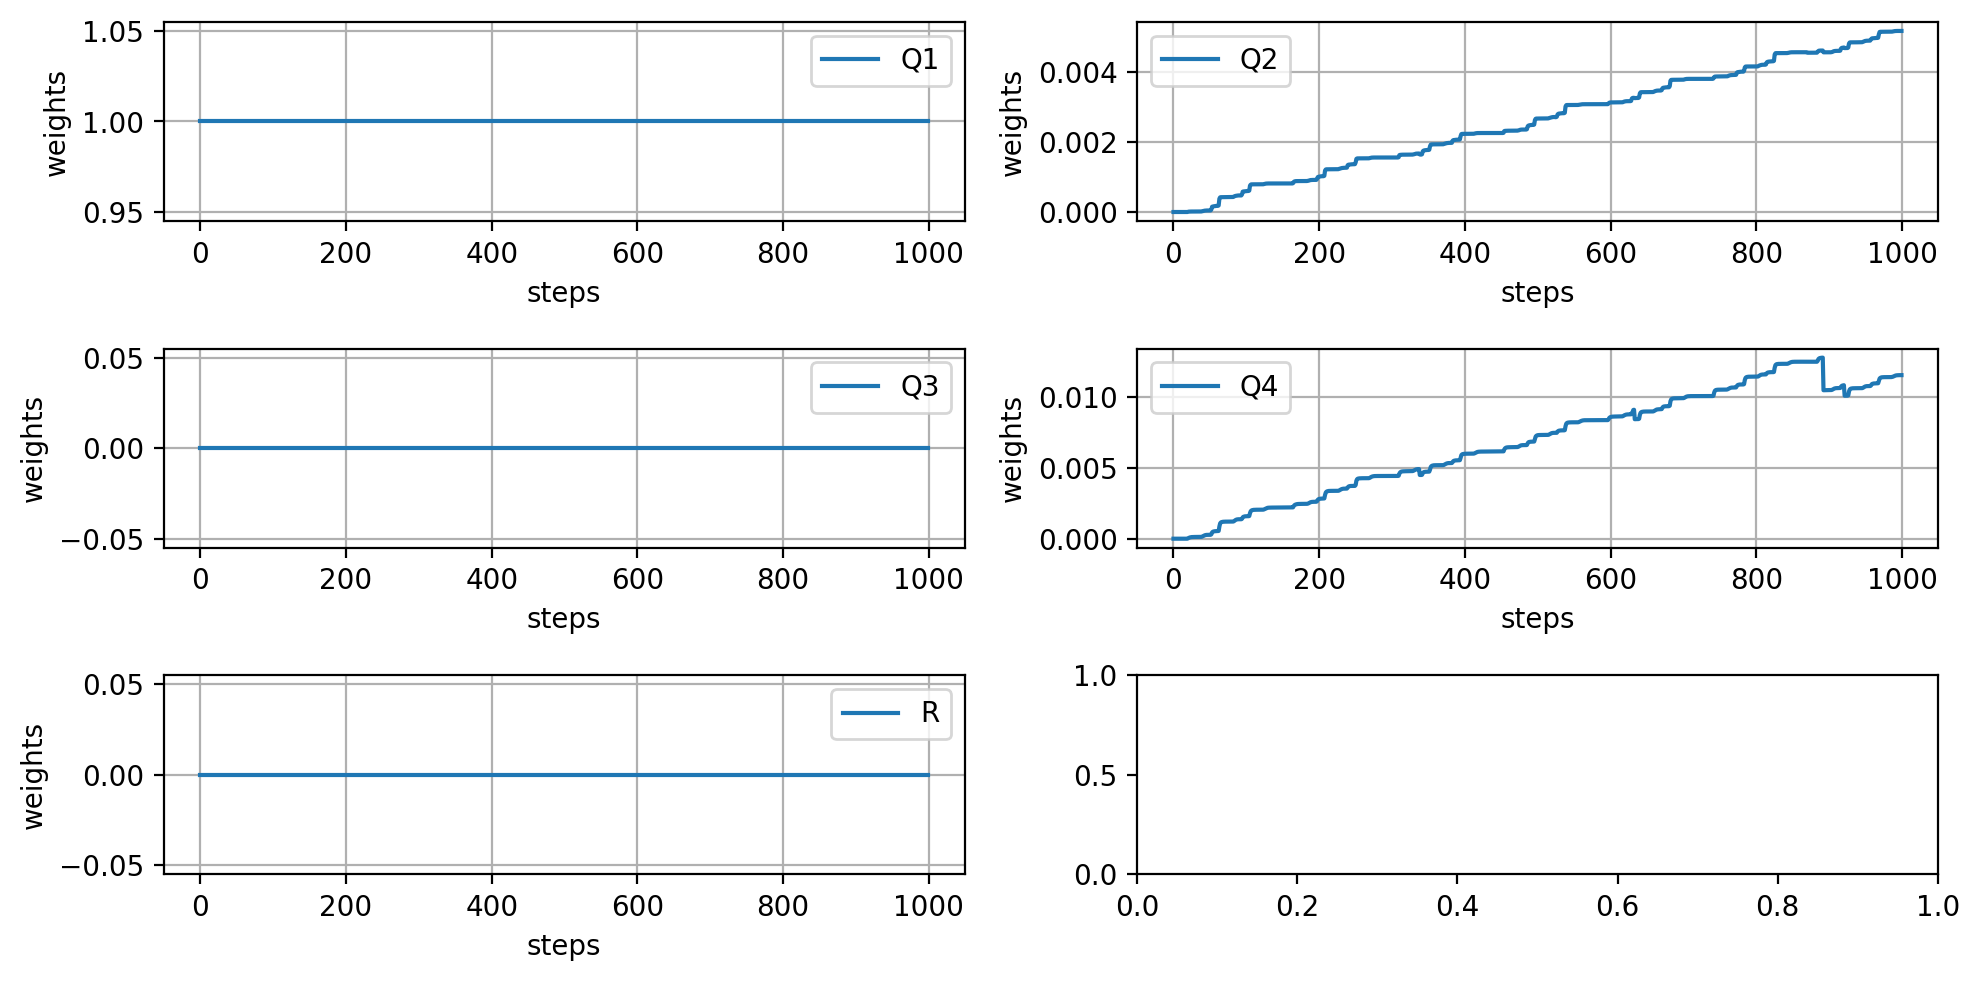

In [282]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,constrained_layout=False, figsize=(10, 5), dpi=200)
ax1.plot(np.array(weights_vect).reshape(-1,6)[:,0], label='Q1')
ax1.legend()
ax1.set_xlabel('steps')
ax1.set_ylabel('weights')
ax1.grid(True)

ax2.plot(np.array(weights_vect).reshape(-1,6)[:,1], label='Q2')
ax2.legend()
ax2.set_xlabel('steps')
ax2.set_ylabel('weights')
ax2.grid(True)

ax3.plot(np.array(weights_vect).reshape(-1,6)[:,2], label='Q3')
ax3.legend()
ax3.grid(True)
ax3.set_xlabel('steps')
ax3.set_ylabel('weights')

ax4.plot(np.array(weights_vect).reshape(-1,6)[:,3], label='Q4')
ax4.legend()
ax4.grid(True)
ax4.set_xlabel('steps')
ax4.set_ylabel('weights')

ax5.plot(np.array(weights_vect).reshape(-1,6)[:,5], label='R')
ax5.legend()
ax5.grid(True)
ax5.set_xlabel('steps')
ax5.set_ylabel('weights')
plt.tight_layout()

In [283]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [284]:
print('weights_vect: ', weights_vect[-1])
print('theta_vect: ', theta_vect[-1])

weights_vect:  [1, 0.00517509, 0, 0.0115135, 0, 0]
theta_vect:  [0.0301995, 0, 0, 0]


Con offset costante su x = 0.005, a partire da beta = 0.0 converge a 0.010 (10000 steps)
Con offset costante su x = 0.01, a partire da beta = 0.0 converge a ?? (10000 steps)
Con offset costante su x = 0.005, a partire da beta = 0.01 converge a ?? (10000 steps)

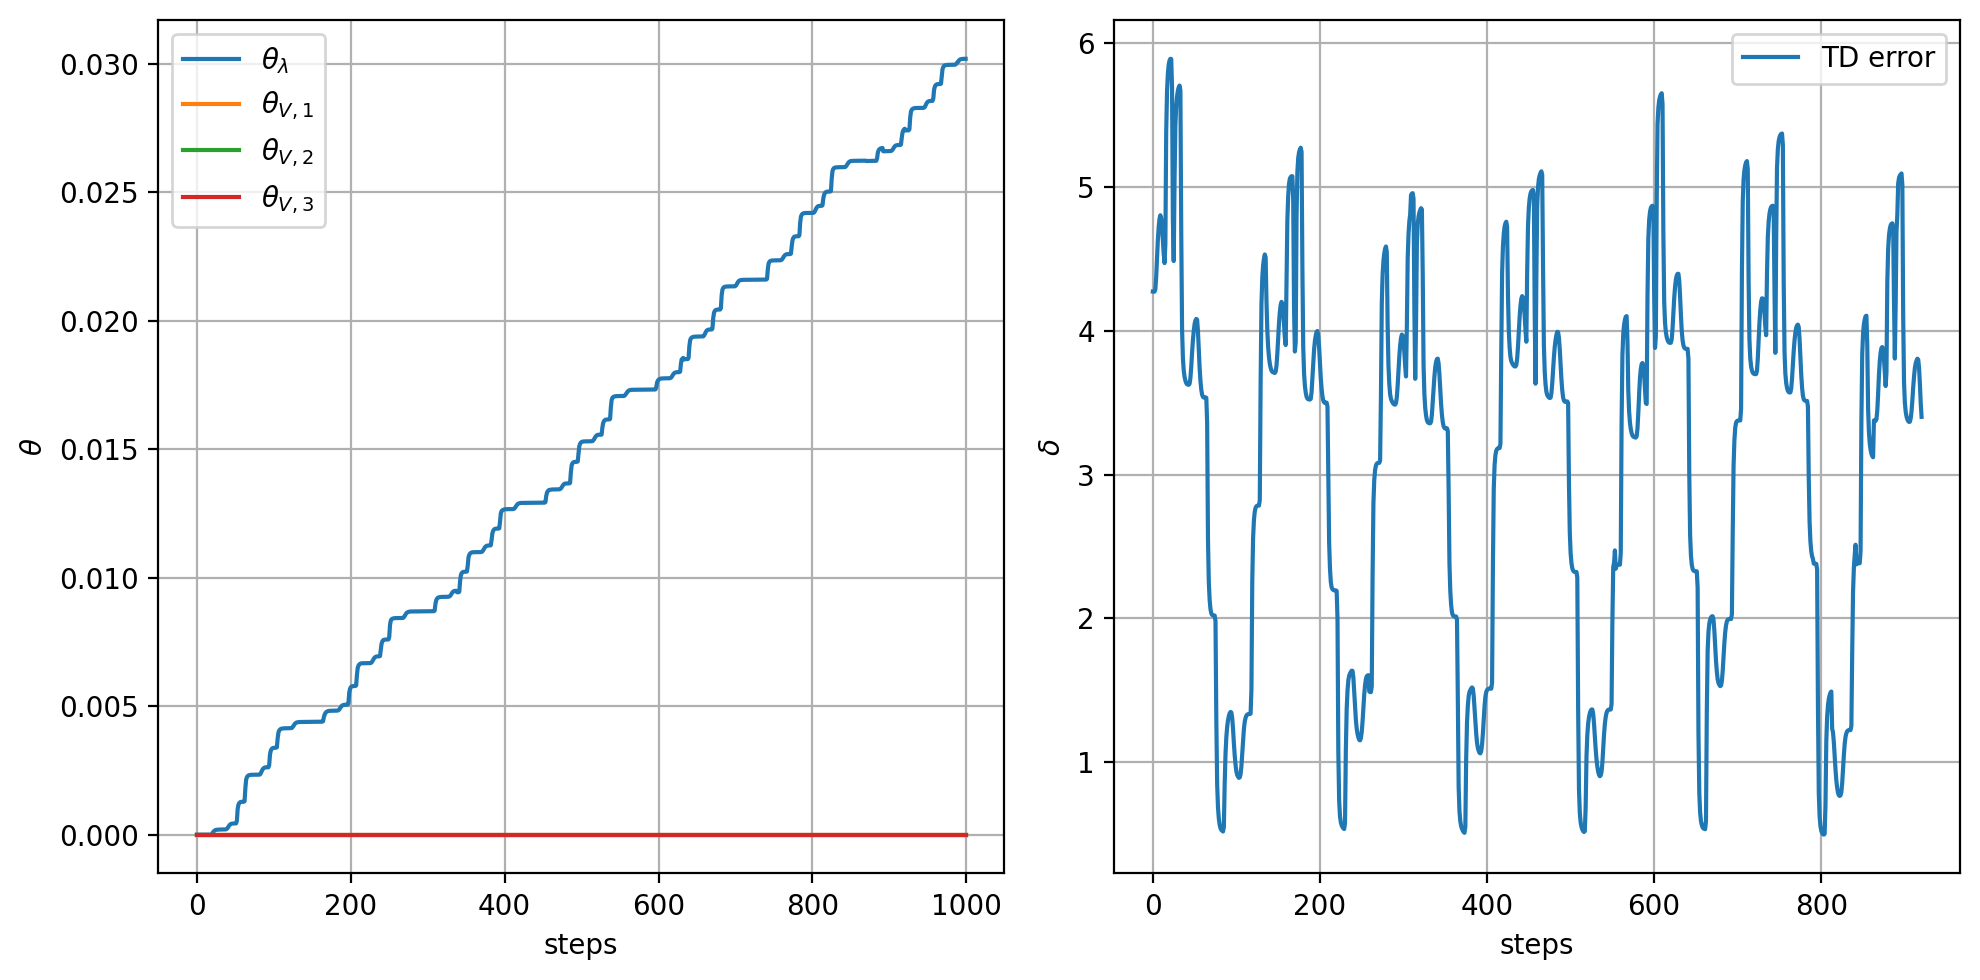

In [285]:
fig, (ax1, ax2) = plt.subplots(1,2,constrained_layout=False, figsize=(10, 5), dpi=200)
ax1.plot(np.array(theta_vect).reshape(-1,4)[:,0], label=r'$\theta_{\lambda}$')
ax1.plot(np.array(theta_vect).reshape(-1,4)[:,1], label=r'$\theta_{V,1}$')
ax1.plot(np.array(theta_vect).reshape(-1,4)[:,2], label=r'$\theta_{V,2}$')
ax1.plot(np.array(theta_vect).reshape(-1,4)[:,3], label=r'$\theta_{V,3}$')
ax1.legend()
ax1.set_xlabel('steps')
ax1.set_ylabel(r'$\theta$')
ax1.grid(True)

ax2.plot(moving_average(np.array(delta_vect[30:]).flatten(), 50), label='TD error')
ax2.legend()
#ax2.plot(np.array(delta_vect).flatten())
ax2.grid(True)
ax2.set_xlabel('steps')
ax2.set_ylabel(r'$\delta$')
plt.tight_layout()

In [286]:
theta_vect[-1]

DM([0.0301995, 0, 0, 0])

In [287]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5999999036276012, max speed is 0.6'

In [288]:
np.mean(X_log[3,:])

0.5272628726051303

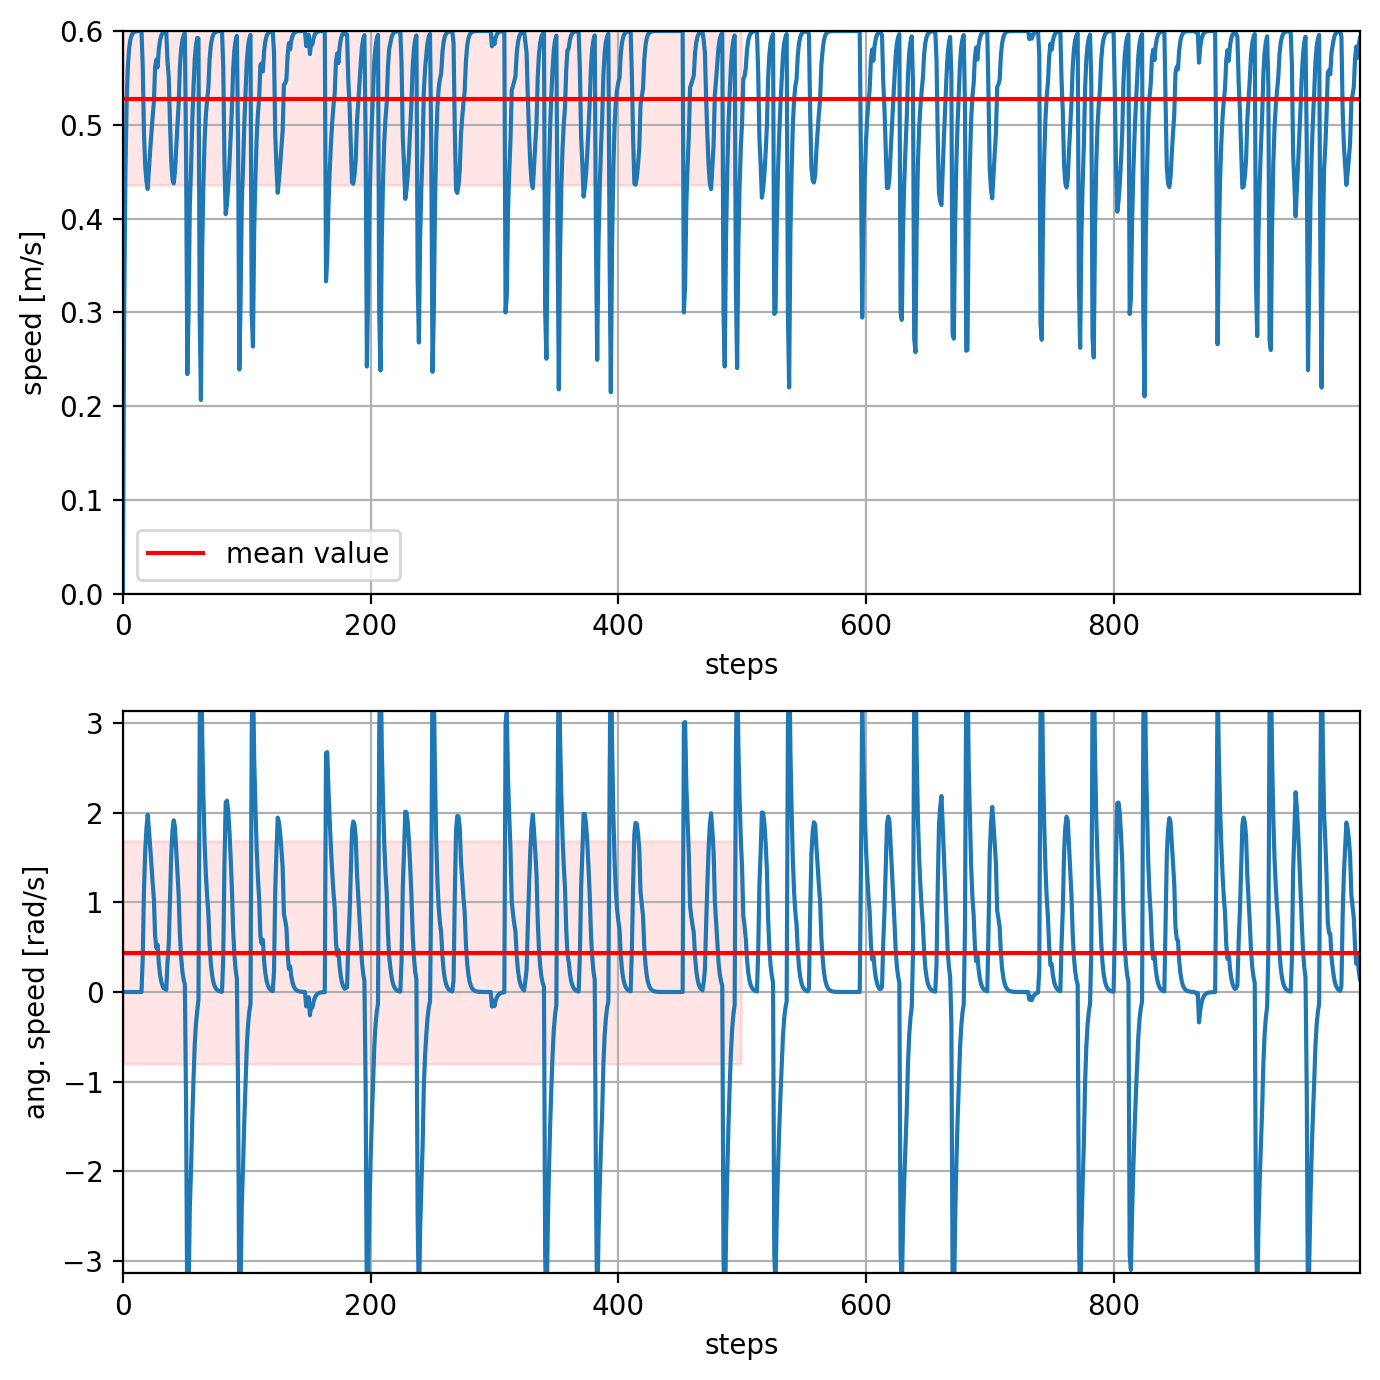

In [289]:
fig, (ax1, ax2) = plt.subplots(2,1, dpi=200)
ax1.plot(moving_average(X_log[3,:],1))
ax1.axhline(np.mean(X_log[3,:]), c='r', label='mean value')
ax1.fill_between(np.arange(500), np.mean(X_log[3,:])-np.std(X_log[3,:]),np.mean(X_log[3,:])+np.std(X_log[3,:]), color='r', alpha=0.1)
ax1.grid(True)
ax1.set_xlabel('steps')
ax1.set_ylabel('speed [m/s]')
ax1.set_ylim(0,0.6)
ax1.margins(x=0)
ax1.legend()

ax2.plot(moving_average(X_log[4,:],1))
ax2.axhline(np.mean(X_log[4,:]), c='r', label='mean value')
ax2.fill_between(np.arange(500), np.mean(X_log[4,:])-np.std(X_log[4,:]),np.mean(X_log[4,:])+np.std(X_log[4,:]), color='r', alpha=0.1)
ax2.grid(True)
ax2.set_xlabel('steps')
ax2.set_ylabel('ang. speed [rad/s]')
ax2.set_ylim(-np.pi,np.pi)
ax2.margins(x=0)
plt.tight_layout()

In [290]:
errors = np.array(errors).reshape(-1)
f"Mean error: {errors.mean()}"

'Mean error: 0.062492984657093506'

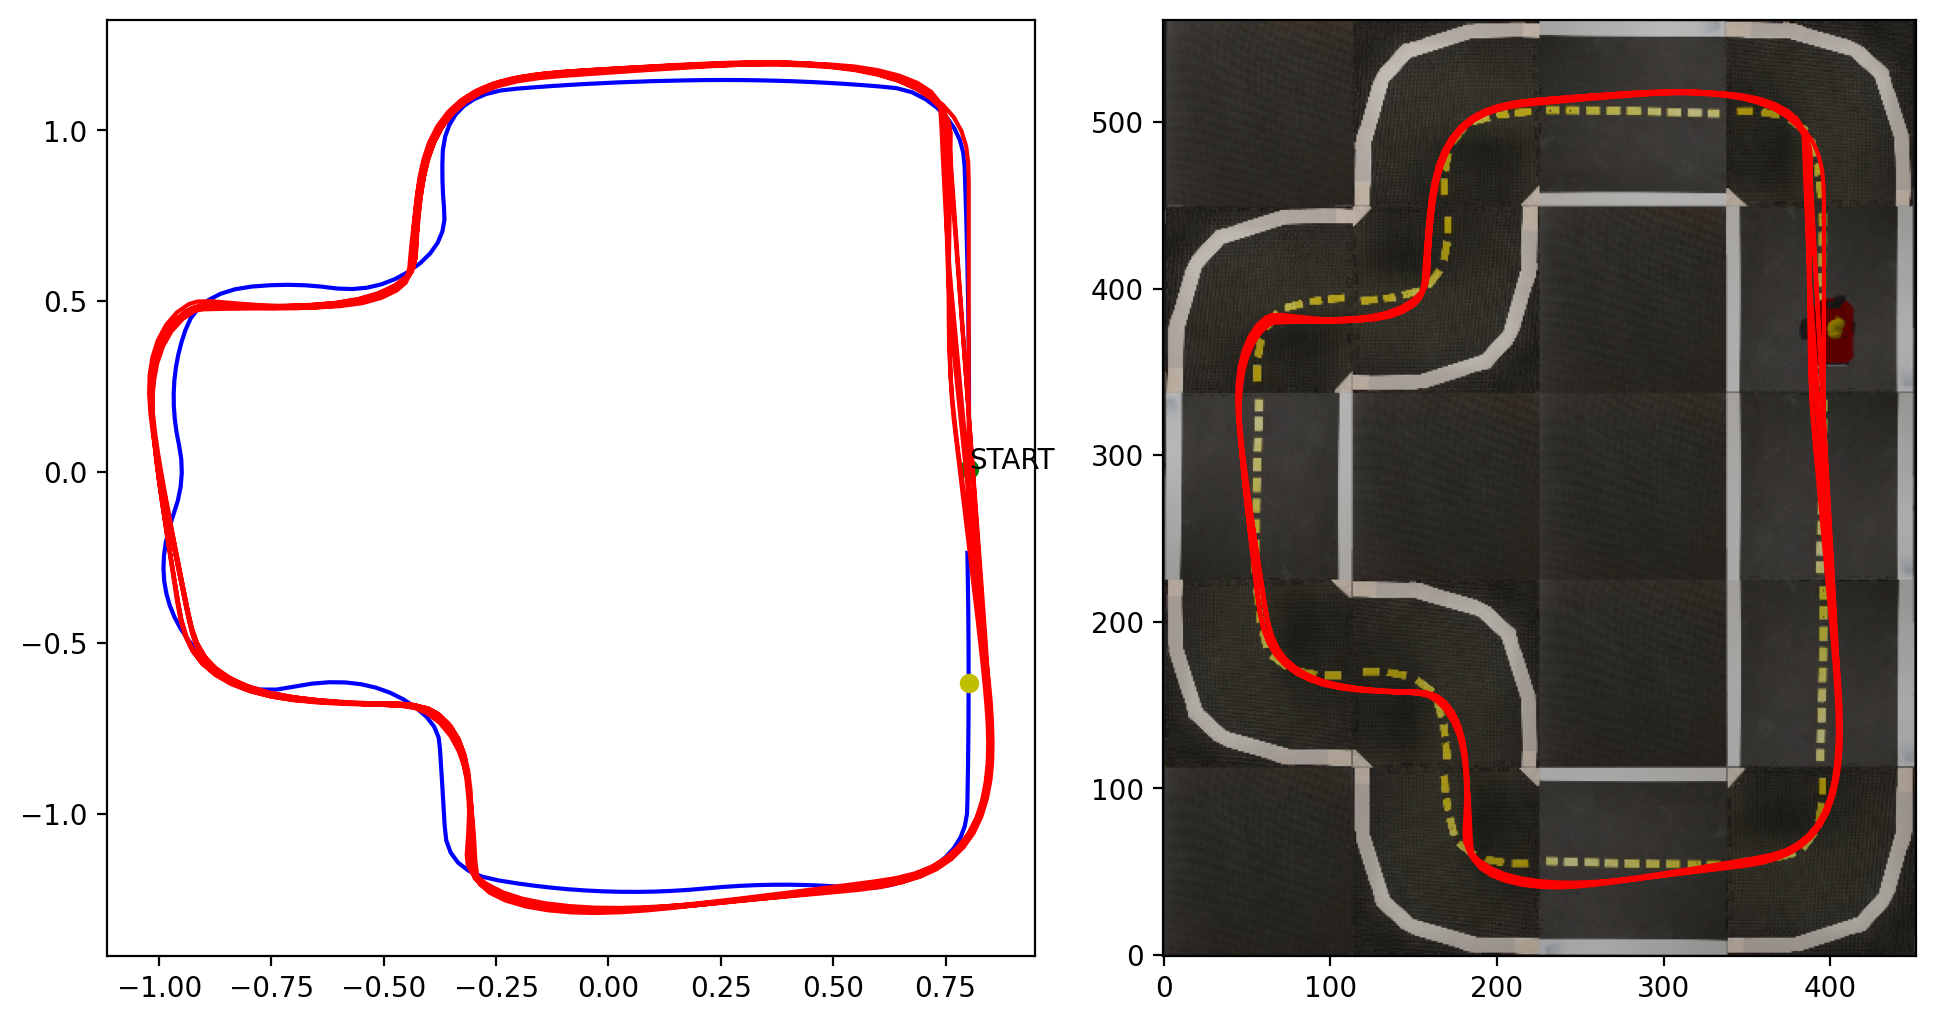

In [291]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5), dpi=200)
traj = np.array(traj)
index = int(index)
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T  - np.array([-1.25, -1.5]), fig=ax_dict["C"])

In [229]:
t*1/10

10.0

In [185]:
print(np.mean(np.abs(curvature_val_observed_tuned)))
print(np.mean(np.abs(curvature_val_observed_non_tuned)))

NameError: name 'curvature_val_observed_tuned' is not defined

In [ ]:
#curvature_val_reference = curvature(traj[:,0], traj[:,1])
#curvature_val_observed_tuned = curvature(X_log[0,:], X_log[1,:])
#curvature_val_observed_non_tuned = curvature(X_log[0,:], X_log[1,:])
#curvature_val = curvature(r[0,:], r[1,:])
#plt.plot(np.array(curvature_val))
plt.figure(figsize=(15,4),dpi=200)
plt.plot(np.array(curvature_val_observed_non_tuned), label='not tuned')
plt.plot(np.array(curvature_val_observed_tuned), label='tuned')
plt.margins(x=0)
plt.grid(True)
plt.legend()
plt.xlabel('steps')

In [ ]:
plt.figure(figsize=(10,5), dpi=200)
#plt.xticks(np.arange(0, len(errors)*dt+1, 1.0))
plt.plot(moving_average(np.sqrt(errors), 5))
plt.axhline(y=0.025, color='r', linestyle='-')
plt.xlabel("steps")
plt.ylabel("Distance from reference (m)")
plt.grid(True)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, np.abs(error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

## Parameters sensitivity

In [ ]:
td_graph = False

### Multi parameter sensitivity

In [484]:
if td_graph:
    errors_Q = []

    for Q_ in np.logspace(-4, 2, 20):
        errors_Q2 = []
        for Q2_ in np.logspace(-4, 2, 20):
            X_log = np.empty((5,0))
            U_log = np.empty((2,0))

            x = [pose.x, pose.y, pose.theta, 0, 0]
            r = r0
            tr = t0
            idx = index
            u_delay = u_delay0
            errors = []
            error_x = []
            error_y = []
            error_theta = []

            kdtree = spatial.KDTree(traj[:, :2])
            for i in range(50):
                u = M(x, r, tr, u_delay, Q_, Q2_, 1, 1)

                U_log = np.column_stack((U_log, u))
                X_log = np.column_stack((X_log, x))

                u_delay = np.column_stack((u_delay, u))[:, -delay:]

                # simulate
                x = F(x,u)

                distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
                errors.append(distance)
                error_x.append(traj[idx, 0] - x[0])
                error_y.append(traj[idx, 1] - x[1])
                error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

                _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
                r = traj[idx:idx+N+1, :2].T
                tr = traj[idx:idx+N+1, 2].T
            errors_Q2.append(np.array(errors).reshape(-1).sum())
        errors_Q.append(errors_Q2)

In [485]:
if td_graph:
    import matplotlib.ticker as mticker
    import matplotlib as mpl

    mpl.style.use("default")
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(np.log10(np.logspace(-4, 2, 20)), np.log10(np.logspace(-4, 2, 20)), np.array(errors_Q), label="J")

    # My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
    def log_tick_formatter(val, pos=None):
        return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
        #return f"{10**val:.2e}"      # e-Notation

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.set_xlabel('Q1', fontsize=15, rotation=0, labelpad=10)
    ax.set_ylabel('Q2', fontsize=15, labelpad=15)
    ax.set_zlabel('J', fontsize=15, rotation=0, labelpad=10)
    ax.yaxis.set_rotate_label(False)

    ax.grid(True)

    ax.set_title('Q1 vs Q2')

#### Sensitivity to Q1/Q2
FIxed Q3 and R

In [38]:
errors_Q = []

for Q_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []
    error_x = []
    error_y = []
    error_theta = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q_, 1, 1e-2, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)
        error_x.append(traj[idx, 0] - x[0])
        error_y.append(traj[idx, 1] - x[1])
        error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q.append(np.array(errors).reshape(-1).sum())

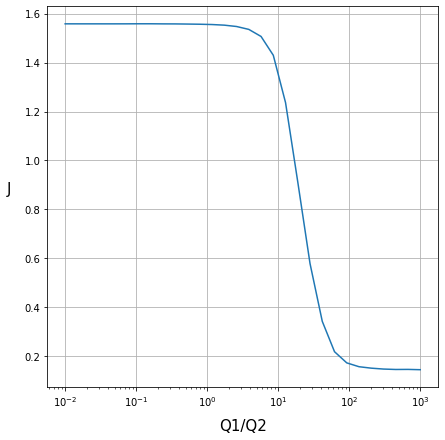

In [61]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q)
ax.set_xlabel('Q1/Q2', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q1 vs Q3

In [57]:
errors_Q2 = []

for Q2_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q2_, 1e-2, 1, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q2.append(np.array(errors).reshape(-1).sum())

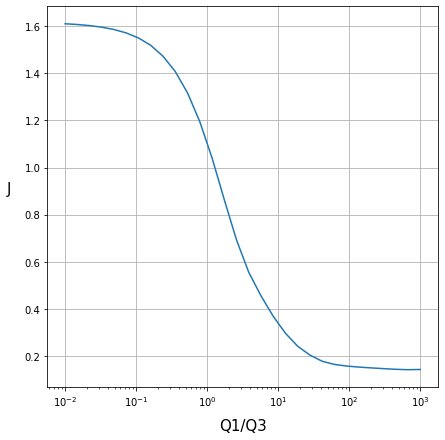

In [63]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q2)
ax.set_xlabel('Q1/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q2/Q3

In [91]:
errors_Q3 = []

for Q3_ in np.logspace(-5, 5, 40):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, 1e2, Q3_, 1, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q3.append(np.array(errors).reshape(-1).sum())

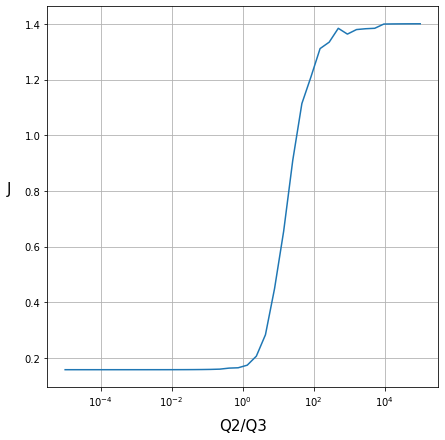

In [92]:
fig, ax = plt.subplots()
x = np.logspace(-5, 5, 40)
ax.plot(x, errors_Q3)

ax.set_xlabel('Q2/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to R

In [45]:
sens_R = False

if sens_R:
    errors_R = []

    for R_ in np.logspace(-4, 2, 20):
        X_log = np.empty((5,0))
        U_log = np.empty((2,0))

        x = [pose.x, pose.y, pose.theta, 0, 0]
        r = r0
        tr = t0
        idx = index
        u_delay = u_delay0
        errors = []

        kdtree = spatial.KDTree(traj[:, :2])
        for i in range(50):
            u = M(x, r, tr, u_delay, 100, 5e-4, 1, R_)

            U_log = np.column_stack((U_log, u))
            X_log = np.column_stack((X_log, x))

            u_delay = np.column_stack((u_delay, u))[:, -delay:]

            # simulate
            x = F(x,u)

            distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
            errors.append(distance)

            _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
            r = traj[idx:idx+N+1, :2].T
            tr = traj[idx:idx+N+1, 2].T
        errors_R.append(np.array(errors).reshape(-1).sum())

In [ ]:
if sens_R:
    fig, ax = plt.subplots()
    x = np.logspace(-4, 2, 20)
    ax.plot(x, errors_R)

    # Set x scale to logarithmic
    ax.set_xscale('log')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [ ]:
M.save('M.casadi')

### Gym simulation

The MPC does not consider the delay yet!

In [ ]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

In [ ]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

In [ ]:
if record:
    utils.show_on_map(env, positions)

In [ ]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))